# Проект: Сегментация клиентов банка по потреблению

**Презентация** ссылка: https://disk.yandex.ru/i/cIN2FF67SzJTBg

*Цель проекта*

Разработать предложения по снижению уровня оттока клиентов банка "Метанпром".

*Задачи проекта*

•	провести исследовательский анализ данных о клиентах банка

•	провести сегментацию клиентов банка исходя из потребления банковских продуктов и иных значимых факторов

•	проверить гипотезы, характеризующие факторы оттока клиентов из банка

•	сформулировать рекомендации по удержанию клиентов банка

*Исходные данные*

Датасет, содержащий данные о клиентах банка (баллы кредитного скоринга, город, пол, возраст, количество объектов в собственности, баланс на счете, количество используемых продуктов, наличие кредитной карты, активность, оценка заработной платы, факт оттока из банка).


## Первичное ознакомление с данными

В рамках данного этапа необходимо загрузить данные, описать их основные характеристики.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import json
import requests 
from urllib.parse import urlencode

In [2]:
# открываем файл из Яндекс.диска
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/JVAJ9uxtV1uydQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url) 

# выводим основную информацию о датасете
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

In [3]:
df['City'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [4]:
df['Gender'].unique()

array(['Ж', 'М'], dtype=object)

In [5]:
df['Age'].unique()

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83], dtype=int64)

In [6]:
df['Products'].unique()

array([1, 3, 2, 4], dtype=int64)

In [7]:
df['Loyalty'].unique()

array([1, 0], dtype=int64)

In [8]:
df['Churn'].unique()

array([1, 0], dtype=int64)

**Промежуточный вывод**

В датасете приведены данные о 10 тыс. пользователей банка "Метанпром", в том числе:

- уникальный номер клиента (userid)
- баллы кредитного рейтинга (score)
- город (City): приведены данные о клиентах из Ярославля, Рыбинска и Ростова Великого.
- пол клиента (Gender)
- возраст (Age)
- количество объектов недвижимости у клиента (Objects)
- баланс счета (Balance)
- количество используемых банковских продуктов (Products)
- наличие кредитной карты (CreditCard)
- показатель активности клиента (Loyalty): 1 - клиент активный, 0 - клиент не активный
- оценка заработной платы клиента (estimated_salary)
- факт ухода клиента из банка (Churn): 1 - клиент ушел из банка, 0 - клиент не ушел из банка.

Наименования столбцов на этапе предобработки данных целесообразно привести к одному стилю.

Все данные, за исключением наименований городов и пола заемщиков, числовые (целые либо дробные). На этапе предобработки данных необходимо проверить их на наличие некорректных (например, отрицательных) значений. 

Для последующих этапов анализа может потребоваться категоризация данных. Например, данные по возрасту клиентов целесообразно укрупнить до возрастных групп. Возможна категоризация и по другим позициям (кредитный рейтинг, оценка заработной платы).

В столбце "баланс счета" имеются пропуски (заполнено 6383 значение из 10000). Необходимо провести исследование пропусков на этапе предобработки данных.


## Предварительная обработка данных

На втором этапе будут проведены:

- корректировка наименований столбцов;
- проверка датасета на наличие дубликатов;
- проверка датасета на наличие пропусков и анализ пропусков в различных разрезах, обоснование возможности заполнения пропусков либо целесообразности исключения пропущенных значений;
- первичный анализ корректности заполнения данных в датасете (например, отсутствие отрицательных значений)
- первичная категоризация данных с введением дополнительных переменных (например, выделение возрастных групп клиентов, групп по доходам)

In [9]:
# Переименуем столбцы датасета для дальнейшей работы
df.columns = [x.lower() for x in df.columns]
df = df.rename(columns={'creditcard':'credit_card'})
display(df.head(5))

userid  score       city gender  age  objects    balance  products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   credit_card  loyalty  estimated_salary  churn  
0            1        1         101348.88      1  
1            0        1         112542.58      0  
2            1        0         113931.57      1  
3            0        0          93826.63      0  
4            1        1          79084.10      0

In [10]:
#Проверим данные на наличие полных дубликатов
print('Дублирующих значений:', len(df) - len(df.drop_duplicates()))
print('Дублирующие значения в % от массива:', round((len(df) - len(df.drop_duplicates()))*100.0/len(df),2))

Дублирующих значений: 0
Дублирующие значения в % от массива: 0.0


Явных дубликатов в датасете не выявлено.

In [11]:
#Проверим отсутствие повторов по столбцу userid
len(df['userid'].unique())

10000

Повторные записи, относящиеся к одному и тому же клиенту отсутствуют.

In [12]:
#оценим корректность заполнения данных в числовых столбцах
print('Баланс, минимум:', df['balance'].min(),
      'Баланс, максимум:', df['balance'].max())

Баланс, минимум: 3768.69 Баланс, максимум: 250898.09


Случаи отрицательных или очень высоких остатков на счетах отсутствуют.

In [13]:
print('Оценка заработной платы, минимум:', df['estimated_salary'].min(),
      'Оценка заработной платы, максимум:', df['estimated_salary'].max())

Оценка заработной платы, минимум: 11.58 Оценка заработной платы, максимум: 199992.48


Отрицательных оценок заработной платы нет, но есть очень низкие оценки (минимум - 11,58 руб.) Вероятно, модель расчета заработной платы не учитывает некоторые факторы.

Распределение оценки заработной платы


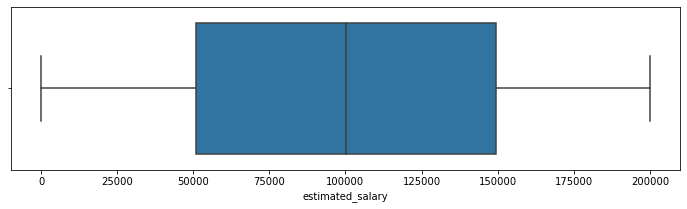

In [14]:
print('Распределение оценки заработной платы')
plt.figure(figsize=(12, 3))
fig = sns.boxplot(data=df, x="estimated_salary")
plt.show()

In [15]:
df['objects'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

У клиентов банка от 0 до 10 объектов недвижимости в собственности. Это вполне возможно.

In [16]:
# Рассмотрим общее количество пропусков
print('Пропущенных значений:')
print(df['balance'].isna().sum())

Пропущенных значений:
3617


In [17]:
# Создадим отдельный столбец с данными о пропусках
df['missing'] = df['balance'].isna()
# Проанализируем распределение пропусков данных о балансе в разрезе различных признаков
# Рассмотрим пропуски по филиалам городов
df.groupby('city')['missing'].sum()

city
Ростов Великий       0
Рыбинск           1199
Ярославль         2418
Name: missing, dtype: int64

Пропущенные данные о балансе клиентов есть в Рыбинске и Ярославле; пропусков в данных по клиентам в Ростове Великом нет.

In [18]:
# Посмотрим, насколько число пропущенных значений велико относительно общего числа клиентов по городам
df.groupby('city')['userid'].count()

city
Ростов Великий    2509
Рыбинск           2477
Ярославль         5014
Name: userid, dtype: int64

Отметим, что и в Рыбинске, и в Ярославле, пропущены данные о балансе значительного числа (около половины) всех клиентов.

In [19]:
# Рассмотрим пропуски по факту ухода из банка
df.groupby('churn')['missing'].sum()

churn
0    3117
1     500
Name: missing, dtype: int64

Большинство пропущенных значений относится к действующим клиентам; по ушедшим клиентам банка также есть пропуски, но их меньше.

In [20]:
# Рассмотрим пропуски по признаку активности клиентов
df.groupby('loyalty')['missing'].sum()

loyalty
0    1744
1    1873
Name: missing, dtype: int64

Пропущенные данные о балансе клиента есть как среди активных клиентов банка, так и среди клиентов, не считающихся активными.

In [21]:
# Рассмотрим пропуски в зависимости от количества продуктов, которыми пользуются клиенты банка
df.groupby('products')['missing'].sum()

products
1     905
2    2600
3      98
4      14
Name: missing, dtype: int64

Пропуск данных о балансе клиента не зависит от числа используемых продуктов: пропуски встречаются даже среди тех, кто пользуется 4 продуктами банка.

In [22]:
# Рассмотрим пропуски в зависимости от наличия кредитной карты у клиента банка
df.groupby('credit_card')['missing'].sum()

credit_card
0    1025
1    2592
Name: missing, dtype: int64

Пропуски данных встречаются как среди владельцев кредитных карт, так и среди тех, кто не пользуется данным инструментом.

В целом, анализ пропусков показал, что пропущенные данные о балансе встречаются в двух из трех филиалов банка (в г. Ярославль и г. Рыбинск). При этом факт пропуска данных не зависит от факта ухода клиента, признаков его активности, количества используемых продуктов, наличия кредитной карты, возраста, оценки уровня заработной платы или кредитного рейтинга.

Можно предположить, что в г.Ярославле и г. Рыбинск данные об остатках на счетах клиентов стали вносить в базу данных недавно, и поэтому по части клиентов они отсутствуют.

In [23]:
# Рассмотрим столбец с кредитным рейтингом
print('минимальный рейтинг', df['score'].min())
print('медианный рейтинг', df['score'].median())
print('максимальный рейтинг', df['score'].max())

минимальный рейтинг 350
медианный рейтинг 652.0
максимальный рейтинг 850


In [24]:
#Выделим различные категории клиентов в зависимости от их кредитного рейтинга

def score_group(score):
    """
    Возвращает группу кредитного рейтинга по значению рейтинга score, используя правила:
    - 'низкий рейтинг', если score <= 550;
    - 'средний рейтинг', если score от 550 до 750;
    - 'высокий рейтинг' — выше 750.
    """
    
    if score <= 550:
        return 'низкий'
    if score <= 750:
        return 'средний'
    return 'высокий'

df['score_group'] = df['score'].apply(score_group)
print(df['score_group'].value_counts()) 

средний    6781
низкий     1621
высокий    1598
Name: score_group, dtype: int64


In [25]:
#Рассмотрим распределение пропусков в зависимости от группы кредитного рейтинга
df.groupby('score_group')['missing'].sum()

score_group
высокий     552
низкий      593
средний    2472
Name: missing, dtype: int64

Пропуски данных о балансе клиентов встречаются у клиентов всех групп кредитного рейтинга.

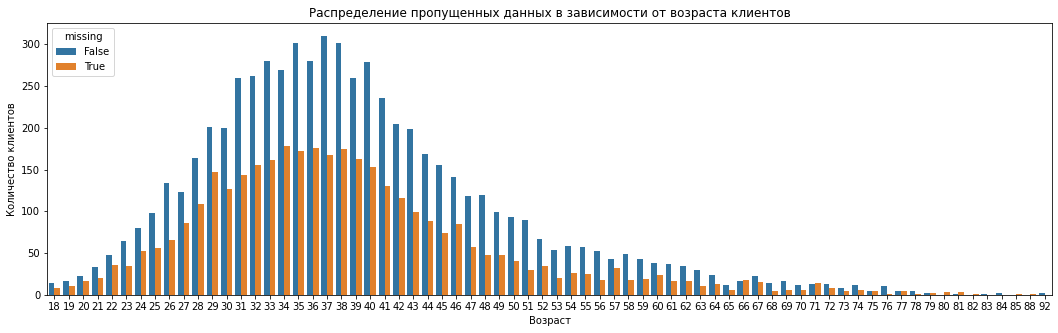

In [28]:
# Рассмотрим распределение пропусков по возрасту клиентов

plt.figure(figsize=(18, 5))
ax = sns.countplot(data=df, x="age", hue="missing")
ax.set_title('Распределение пропущенных данных в зависимости от возраста клиентов')
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество клиентов')
plt.show()

In [29]:
#Для целей дальнейшего анализа выделим различные категории клиентов в зависимости от возраста клиентов

def age_group(age):
    """
    Возвращает группу клиентов в зависимости от их возраста:
    - 'молодежь', если age <= 29 лет;
    - 'средний возраст', если age от 30 до 45;
    - 'выше среднего', если age от 45 до 60;
    - 'пенсионеры', если age выше 60
    """
    
    if age <= 29:
        return 'молодежь'
    if age <= 45:
        return 'средний возраст'
    if age <= 60:
        return 'выше среднего'
    return 'пенсионеры'

df['age_group'] = df['age'].apply(age_group)
print(df['age_group'].value_counts()) 

средний возраст    6248
выше среднего      1647
молодежь           1641
пенсионеры          464
Name: age_group, dtype: int64


In [30]:
#Рассмотрим распределение пропусков по возрастным группам

df.groupby('age_group')['missing'].sum()

age_group
выше среднего       526
молодежь            643
пенсионеры          167
средний возраст    2281
Name: missing, dtype: int64

Пропущенные данные о балансе клиентов не зависят от их возраста.

In [31]:
#Выделим различные категории клиентов в зависимости от оценки их заработной платы

def income_group(income):
    """
    Возвращает группу клиентов в зависимости от оценки их заработной платы estimated_salary:
    - 'низкая', если estimated_salary <= 50000;
    - 'ниже среднего', если estimated_salary от 50000 до 100000;
    - 'выше среднего', если estimated_salary от 100000 до 150000;
    - 'высокая', если estimated_salary выше 150000
    """
    
    if income <= 50000:
        return 'низкая'
    if income <= 100000:
        return 'ниже средней'
    if income <= 150000:
        return 'выше средней'
    return 'высокая'

df['income_group'] = df['estimated_salary'].apply(income_group)
print(df['income_group'].value_counts()) 

выше средней    2555
ниже средней    2537
высокая         2455
низкая          2453
Name: income_group, dtype: int64


In [32]:
#Рассмотрим распределение пропусков в зависимости от оценки заработной платы
df.groupby('income_group')['missing'].sum()

income_group
высокая         873
выше средней    908
ниже средней    921
низкая          915
Name: missing, dtype: int64

Пропуски данных встречаются у клиентов как с низкой, так и с высокой заработной платой.

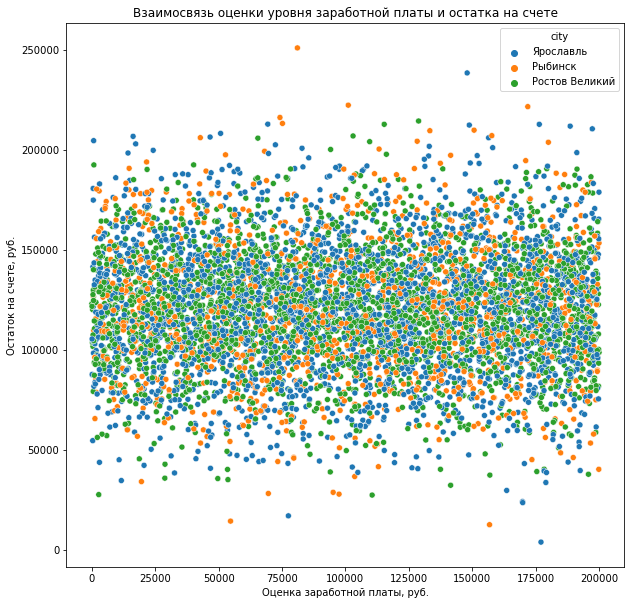

In [37]:
# Рассмотрим, насколько коррелируют значения баланса и оценки заработной платы

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=df, x="estimated_salary", y="balance", hue="city")
ax.set_title('Взаимосвязь оценки уровня заработной платы и остатка на счете')
ax.set_xlabel('Оценка заработной платы, руб.')
ax.set_ylabel('Остаток на счете, руб.')
plt.show()

Зависимости между оценкой заработной платы и балансом на счету не выявлено.

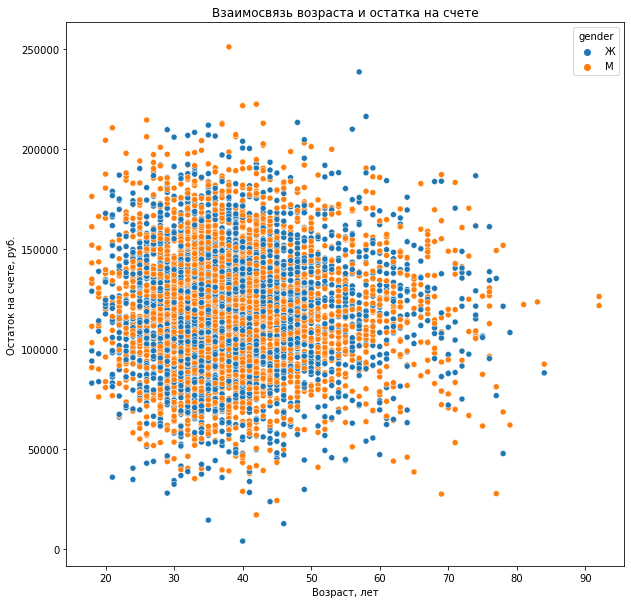

In [35]:
# Рассмотрим, насколько коррелируют возраст и остаток на счету
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=df, x="age", y="balance", hue="gender")
ax.set_title('Взаимосвязь возраста и остатка на счете')
ax.set_xlabel('Возраст, лет')
ax.set_ylabel('Остаток на счете, руб.')
plt.show()

Зависимости между возрастом и размером остатка на счету также нет.

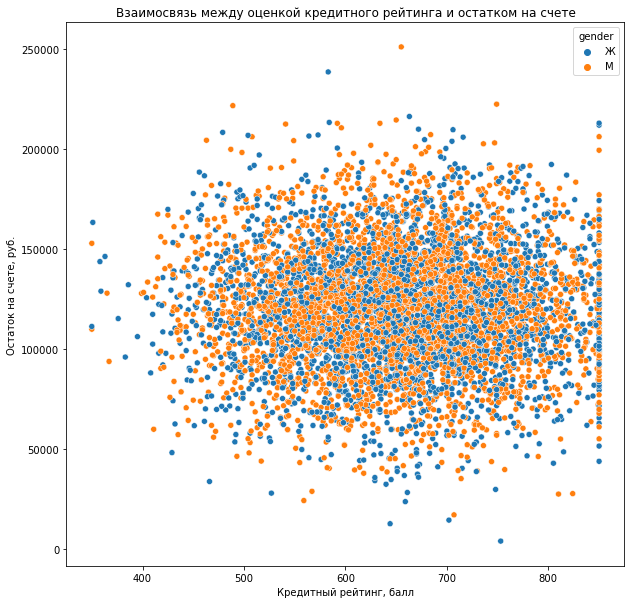

In [36]:
# Рассмотрим, насколько коррелируют кредитный рейтинг и остаток на счету
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=df, x="score", y="balance", hue="gender")
ax.set_title('Взаимосвязь между оценкой кредитного рейтинга и остатком на счете')
ax.set_xlabel('Кредитный рейтинг, балл')
ax.set_ylabel('Остаток на счете, руб.')
plt.show()

**Промежуточный вывод**

Анализ пропусков показал, что пропущенные данные о балансе встречаются в двух из трех филиалов банка (в г. Ярославль и г. Рыбинск). При этом факт пропуска данных не зависит от факта ухода клиента, признаков его активности, количества используемых продуктов, наличия кредитной карты, возраста, оценки уровня заработной платы или кредитного рейтинга.

Можно предположить, что в г.Ярославле и г. Рыбинск данные об остатках на счетах клиентов стали вносить в базу данных недавно, и поэтому по части клиентов они отсутствуют.

Оценка заработной платы, возраст, кредитный рейтинг не коррелируют с балансом на счету клиента, что не позволяет использовать указанные признаки для более точного заполнения пропусков. Пропуски составляют значительную часть общей базы, и исключение из анализа указанных клиентов для всего этапа исследовательского анализа может привести к некорректным выводам.

В этой связи предлагается:
- для анализа всех признаков, кроме признака "баланс", использовать исходный датасет;
- для анализа признака "баланс" использовать датасет с исключением данных о клиентах, по которым данные о балансе отсутствуют.

## Исследовательский анализ данных

На третьем этапе будут проведены:

- анализ распределения признаков по датасету в целом;
- корреляционный анализ признаков.

In [38]:
# Создадим функцию для отображения графиков распределения признаков датасета
def hist_graph(data, parameter, hue, title, title_parameter):
    """
    Возвращает график распределения признака parameter по датасету 
    с учетом различий по признаку hue.
    """
    sns.set_palette('pastel')
    plt.figure(figsize=(12, 5))
    ax = sns.countplot(data=data, x=parameter, hue=hue)
    ax.set_title(title)
    ax.set_xlabel(title_parameter)
    ax.set_ylabel('Количество клиентов')
    return plt.show()



In [39]:
# Создадим функцию для отображения распределений в форме "ящик с усами" и выведения основных статистик
def boxplot_graph(data, parameter, group, hue, title, title_parameter, title_group):
    """
    Возвращает график распределения признака parameter по датасету 
    с учетом различий по признаку group и параметру различий hue.
    """
    sns.set_palette('pastel')
    plt.figure(figsize=(14, 8))
    ax = sns.boxplot(data=data, x=parameter, y=group, hue=hue)
    ax.set_title(title)
    ax.set_xlabel(title_parameter)
    ax.set_ylabel(title_group)
    return plt.show()



In [40]:
# Создадим функцию для вывода основных статистик датасета по выбранному признаку
def key_stat(parameter, parameter_title):
    """
    Возвращает основные статистики признака parameter.
    """
    return print(parameter_title, 
           'максимальное значение:', parameter.max(),
           'минимальное значение:', parameter.min(),
           'медианное значение:', parameter.median(),
           'среднее значение:', parameter.mean()
                )


Распределение по возрасту. максимальное значение: 92 минимальное значение: 18 медианное значение: 37.0 среднее значение: 38.9218


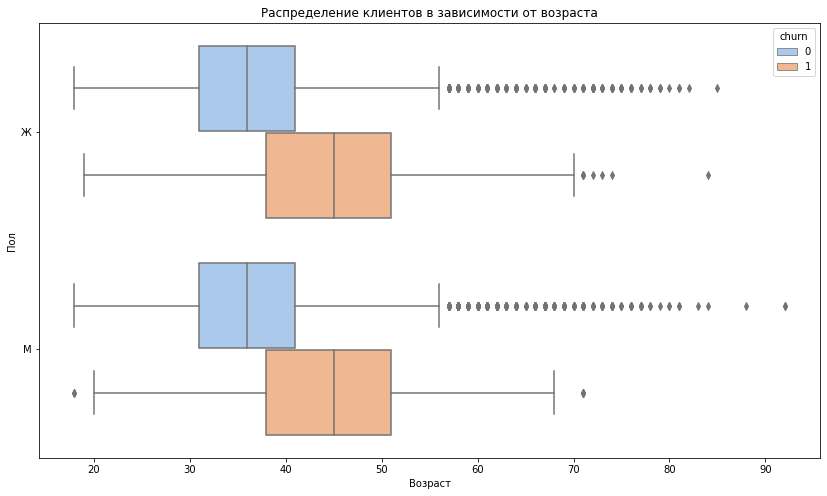

In [42]:
# С использованием функций рассмотрим социально-демографические характеристики датасета

key_stat(df['age'], 'Распределение по возрасту.')
boxplot_graph(df,"age", "gender", "churn", 'Распределение клиентов в зависимости от возраста', 'Возраст','Пол')


В целом возраст клиентов банка варьируется от 18 до 92 лет. Медианный возраст 37 лет. При сопоставлении распределения возрастов оставшихся и ушедших клиентов отмечаются существенные различия: медианный возраст ушедших клиентов составляет 45 лет, половина ушедших клиентов - люди в возрасте от 38 до 52 лет. Тенденция справедлива и для мужчин, и для женщин.

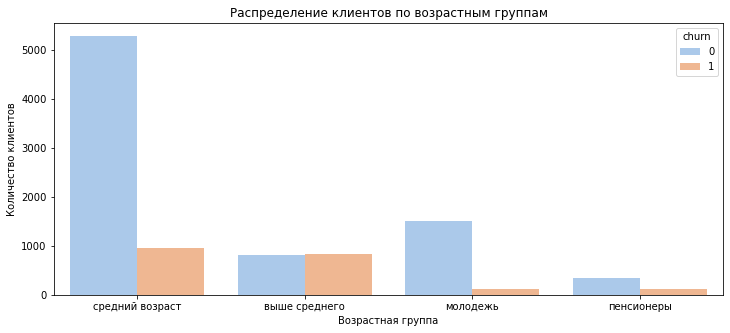

In [43]:
# Рассмотрим распределение оставшихся и ушедших клиентов по возрастным группам

hist_graph(df, "age_group", "churn", 'Распределение клиентов по возрастным группам', 'Возрастная группа') 

Наибольший относительный отток клиентов отмечается в группе клиентов возрастной группы "выше среднего" (старше 45 и моложе 60 лет). Это единственная возрастная группа, где число ушедших клиентов превышает число оставшихся. 

Существенный отток отмечается и в группе клиентов-пенсионеров и в группе клиентов среднего возраста (поскольку клиенты среднего возраста - от 30 до 45 лет - составляют большинство клиентов банка, в абсолютном выражении больше всего ушедших клиентов приходится на эту возрастную группу).

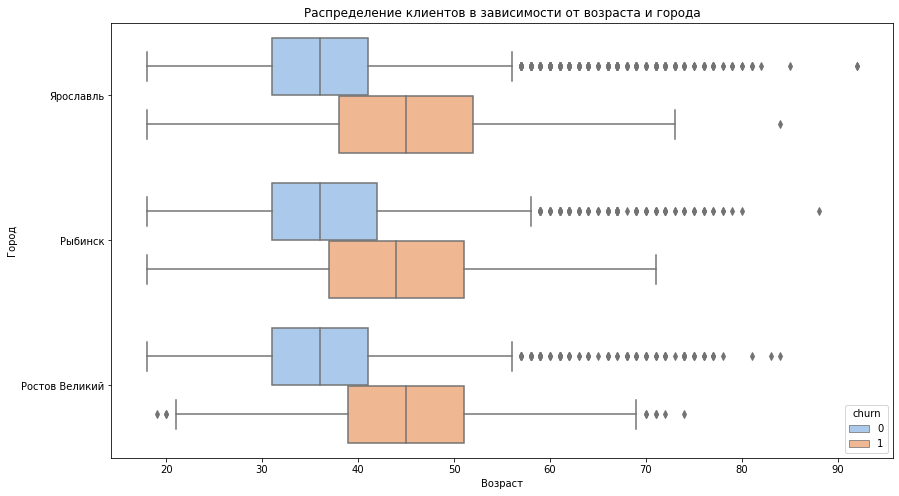

In [44]:
boxplot_graph(df,"age", "city", "churn", 'Распределение клиентов в зависимости от возраста и города', 'Возраст','Город')

Тенденция оттока из банка более возрастных клиентов характерна для всех городов, где работают отделения банка. В Ярославле и Ростове Великом медианный возраст ушедших клиентов немного выше, чем в Рыбинске.

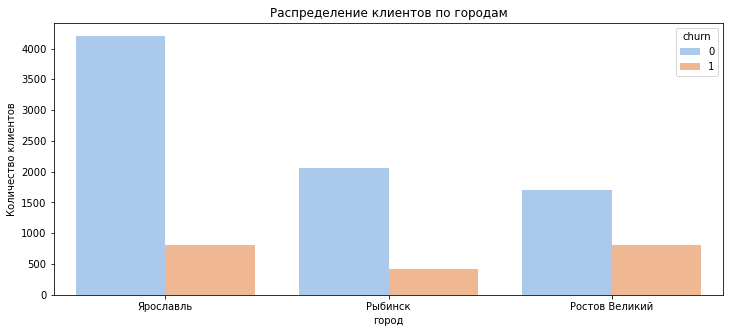

In [45]:
hist_graph(df, "city", "churn", 'Распределение клиентов по городам', 'город') 

In [46]:
df.groupby(['city','churn'])['userid'].count()

city            churn
Ростов Великий  0        1695
                1         814
Рыбинск         0        2064
                1         413
Ярославль       0        4204
                1         810
Name: userid, dtype: int64

Наибольший отток клиентов в относительном и абсолютном выражении наблюдается в Ростове Великом: там ушли 814 клиентов или почти треть клиентов банка. Значительный отток клиентов в абсолютном выражении наблюдается в Ярославле (810 человек), в относительном выражении ситуация в Ярославле и Рыбинске сопоставима.

In [47]:
# Рассмотрим распределение клиентов банка в зависимости от их кредитного рейтинга
key_stat(df['score'], 'Кредитный рейтинг')

Кредитный рейтинг максимальное значение: 850 минимальное значение: 350 медианное значение: 652.0 среднее значение: 650.5288


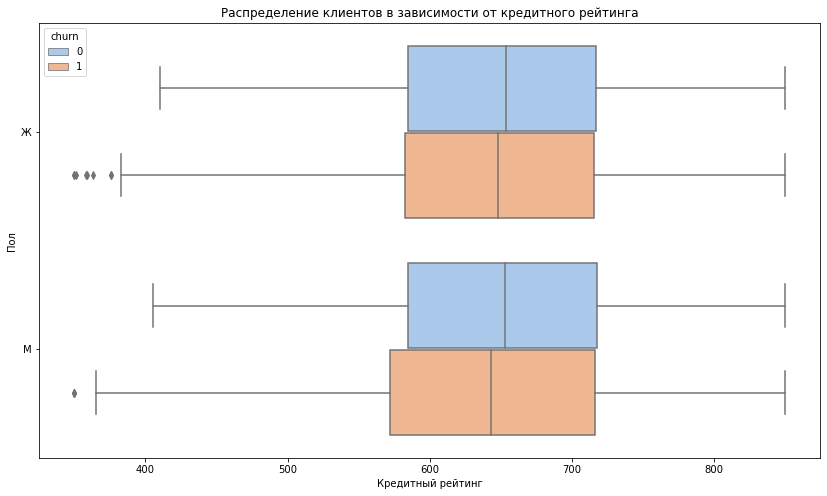

In [49]:
boxplot_graph(
    df,"score", "gender", "churn", 'Распределение клиентов в зависимости от кредитного рейтинга', 'Кредитный рейтинг', 'Пол'
)

In [50]:
df.groupby('churn')['score'].median()

churn
0    653.0
1    646.0
Name: score, dtype: float64

Кредитный рейтинг клиентов банка варьируется от 350 до 850 баллов. Медианный кредитный рейтинг составляет 652 баллов. Отметим, что кредитный рейтинг ушедших клиентов банка несколько ниже кредитного рейтинга оставшихся клиентов (медианное значение кредитного рейтинга 646 баллов у ушедших клиентов, 653 балла у оставшихся клиентов).

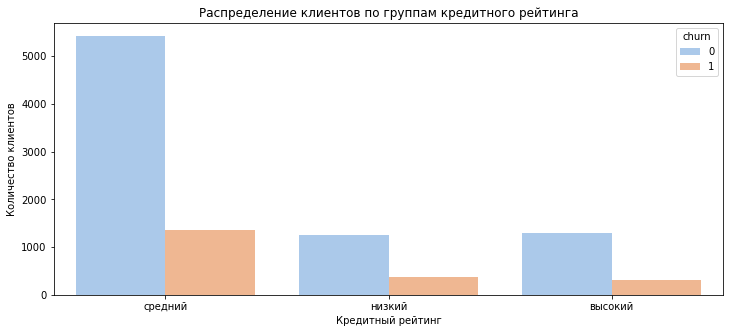

In [51]:
hist_graph(df, "score_group", "churn", 'Распределение клиентов по группам кредитного рейтинга', 'Кредитный рейтинг') 

При этом основная часть ушедших клиентов - это клиенты со средним уровнем кредитного рейтинга (от 550 до 750 баллов). Отмечается отток и среди групп клиентов с низким (менее 550 баллов) и высоким (более 750 баллов) кредитным рейтингом.

Оценка доходов максимальное значение: 199992.48 минимальное значение: 11.58 медианное значение: 100193.915 среднее значение: 100090.2398809998


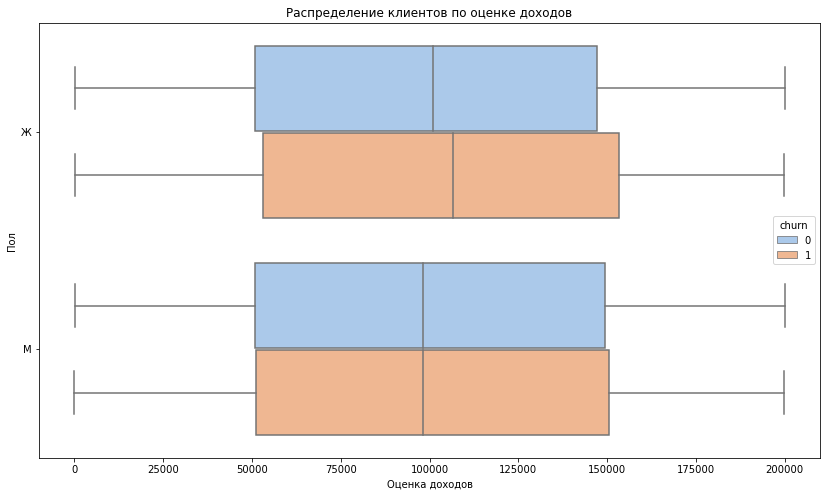

In [52]:
# Рассмотрим распределение клиентов банка в зависимости от доходов
key_stat(df['estimated_salary'], 'Оценка доходов')
boxplot_graph(df,"estimated_salary", "gender", "churn", 'Распределение клиентов по оценке доходов', 'Оценка доходов', 'Пол')

In [53]:
df.groupby('churn')['estimated_salary'].median()

churn
0     99645.04
1    102460.84
Name: estimated_salary, dtype: float64

В среднем по датасету медианная оценка заработной платы клиентов составляет 100193,9 руб. в месяц. Среди клиентов, покинувших банк, медианная оценка заработной платы несколько выше (102460,84 руб.), чем среди оставшихся клиентов (99645,04 руб.). При этом различия в средних доходах между покинувшими банк клиентами и оставшимися отмечаются только в отношении клиентов-женщин.

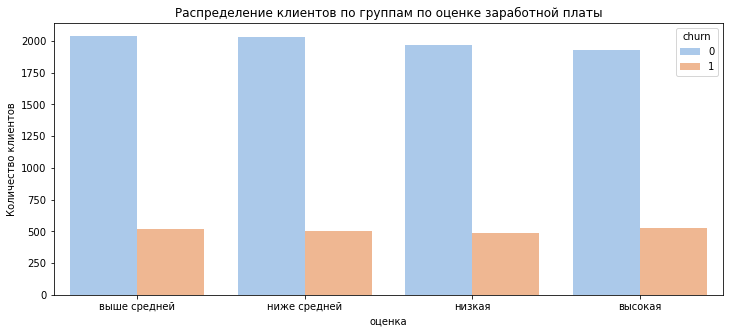

In [54]:
hist_graph(df, "income_group", "churn", 'Распределение клиентов по группам по оценке заработной платы', 'оценка') 

Из графика следует, что отток клиентов наблюдается во всех группах клиентов в зависимости от оценки заработной платы, но в относительном выражении он несколько выше среди клиентов с высокой оценкой заработной платы.

Количество объектов максимальное значение: 10 минимальное значение: 0 медианное значение: 5.0 среднее значение: 5.0128


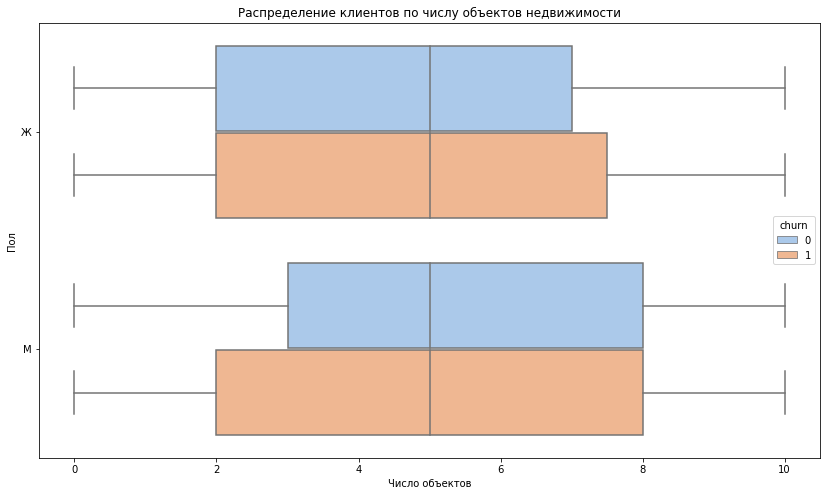

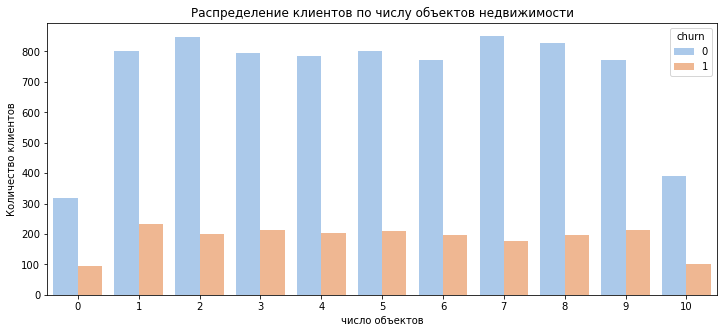

In [55]:
# Рассмотрим распределение клиентов по числу объектов недвижимости
key_stat(df['objects'], 'Количество объектов')
boxplot_graph(df,"objects", "gender", "churn", 'Распределение клиентов по числу объектов недвижимости', 'Число объектов', 'Пол')
hist_graph(df, "objects", "churn", 'Распределение клиентов по числу объектов недвижимости', 'число объектов') 

Среднее число объектов недвижимости в собственности клиента  составляет 5 объектов. Данное число не различается между группами оставшихся и ушедших клиентов. При этом среди ушедших клиентов-мужчин несколько чаще встречались собственники 2 объектов недвижимости, а среди клиентов-женщин - собственники 7 объектов недвижимости.

Количество продуктов. максимальное значение: 4 минимальное значение: 1 медианное значение: 1.0 среднее значение: 1.5302


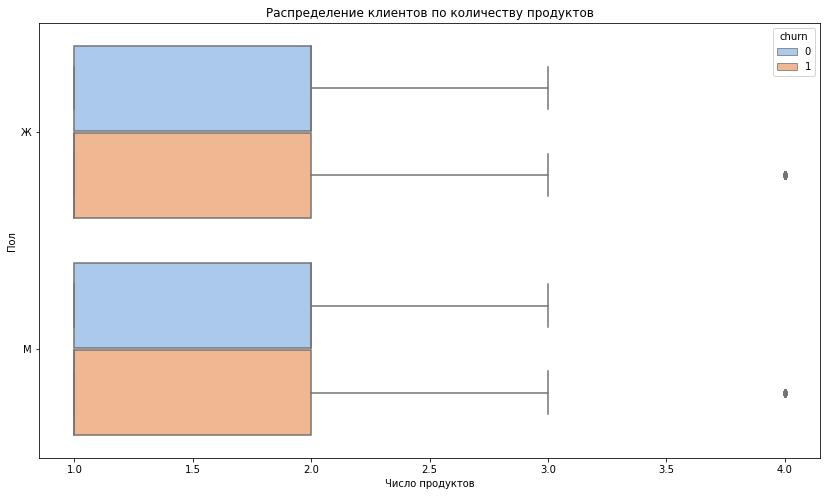

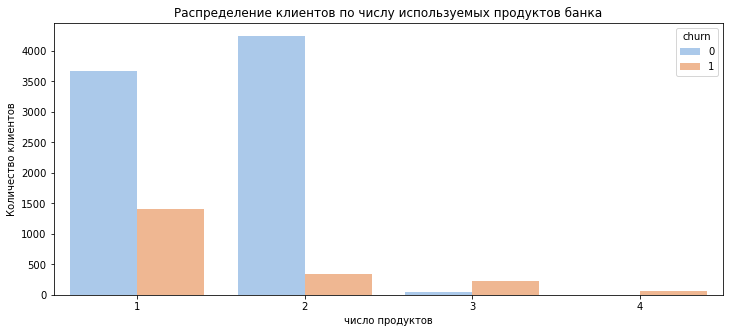

In [56]:
# Рассмотрим распределение клиентов по числу продуктов
key_stat(df['products'], 'Количество продуктов.')
boxplot_graph(df,"products", "gender", "churn", 'Распределение клиентов по количеству продуктов', 'Число продуктов', 'Пол')

hist_graph(df, "products", "churn", 'Распределение клиентов по числу используемых продуктов банка', 'число продуктов') 

In [57]:
prod = df.groupby('products')['userid'].count().reset_index()
print(prod)

   products  userid
0         1    5084
1         2    4590
2         3     266
3         4      60


In [58]:
# Построим круговую диаграмму распределения клиентов по числу используемых продуктов

fig = go.Figure(data=[go.Pie(labels=prod['products'], 
                             values=prod['userid'], 
                             pull = [0.1, 0])]) 
fig.update_layout(title='Распределение клиентов по числу используемых продуктов', 
                  width=800, 
                  height=600,
                  annotations=[dict(x=1.12, 
                                    y=1.05,
                                    text='Количество продуктов',
                                    showarrow=False)])
fig.show() 


Клиенты банка используют от 1 до 4 продуктов. Медианное значение количества используемых продуктов как для оставшихся клиентов, так и для ушедших - 1. Это означает, что половина клиентов банка пользуются только одним продуктом.
90% клиентов банка используют 2 и менее продуктов банка. Четырьмя продуктами банка пользовались лишь отдельные ушедшие клиенты (60 человек в общей выборке 10000).

Такое неравномерное распределение свидетельствует о том, что при сегментации клиентов по числу используемых продуктов банка группы клиентов, использующих 3 и 4 продукта следует объединить.

В относительном выражении наибольший отток отмечается среди клиентов, пользовавшихся 3 или 4 банковскими продуктами. Наименьший отток - среди клиентов, использующих 2 продукта.

Наличие кредитной карты. максимальное значение: 1 минимальное значение: 0 медианное значение: 1.0 среднее значение: 0.7055


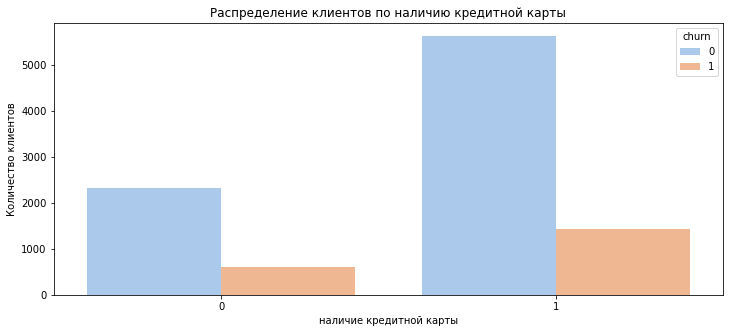

In [59]:
# Рассмотрим распределение клиентов в зависимости от наличия кредитной карты
key_stat(df['credit_card'], 'Наличие кредитной карты.')

hist_graph(df, "credit_card", "churn", 'Распределение клиентов по наличию кредитной карты', 'наличие кредитной карты') 

In [60]:
df.groupby(['churn', 'credit_card'])['userid'].count()

churn  credit_card
0      0              2332
       1              5631
1      0               613
       1              1424
Name: userid, dtype: int64

Кредитной картой пользуются 70,55% клиентов банка. Отток клиентов отмечается как среди клиентов, имеющих кредитную карту, так и среди клиентов, у которых такой карты нет. 

Активность клиента. максимальное значение: 1 минимальное значение: 0 медианное значение: 1.0 среднее значение: 0.5151


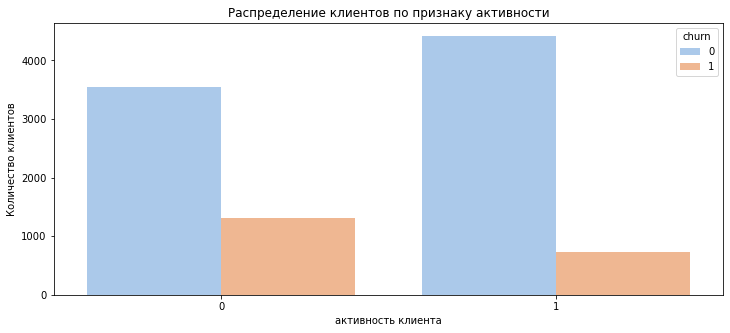

In [61]:
# Рассмотрим распределение клиентов в зависимости от показателя лояльности банку
key_stat(df['loyalty'], 'Активность клиента.')

hist_graph(df, "loyalty", "churn", 'Распределение клиентов по признаку активности', 'активность клиента') 

В целом по выборке 51,51% клиентов отнесены к категории активных. Закономерно, что среди ушедших клиентов активных меньше, чем среди оставшихся. 

In [65]:
# Рассмотрим распределение клиентов банка по размеру остатков на счету
key_stat(df['balance'], 'Остаток на счету.')


Остаток на счету. максимальное значение: 250898.09 минимальное значение: 3768.69 медианное значение: 119839.69 среднее значение: 119827.49379288674


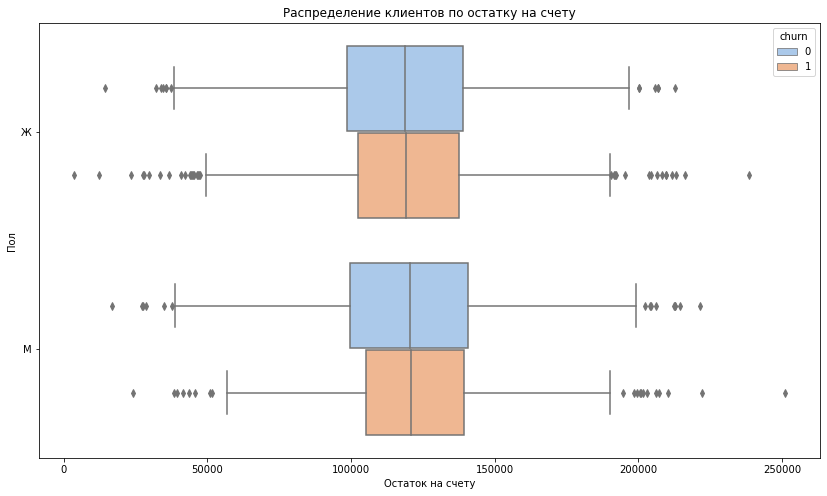

In [66]:
boxplot_graph(df,"balance", "gender", "churn", 'Распределение клиентов по остатку на счету', 'Остаток на счету', 'Пол')


Остаток на счету клиента банка варьируется от 3,8 до 250,9 тыс. руб. Средний остаток составляет 119,8 тыс. руб. и практически не отличается у ушедших и оставшихся клиентов банка. У мужчин остаток на счету незначительно выше, чем у женщин.

In [67]:
# Создадим дамми-переменную для учета городов при расчете матрицы корреляции факторов
city_dummy=pd.get_dummies(data=df['city'])

df['rostov_d'] = city_dummy['Ростов Великий']
df['rybinsk_d'] = city_dummy['Рыбинск']
df['yaroslavl_d'] = city_dummy['Ярославль']


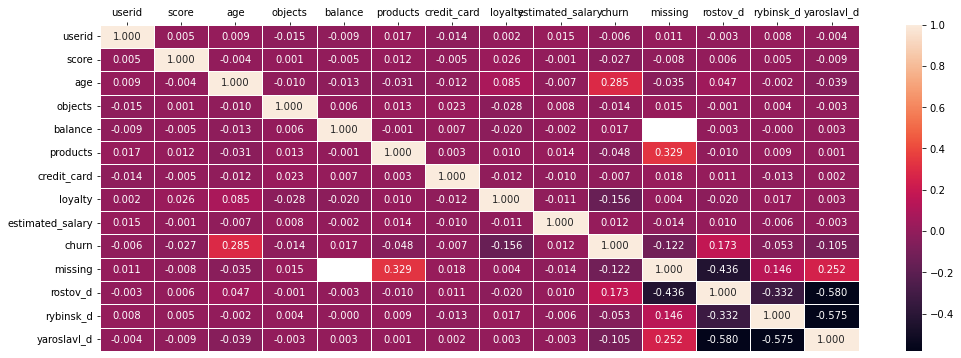

In [68]:
# Рассчитаем матрицу корреляций факторов

plt.figure(figsize=(17,6))
ax = sns.heatmap(data=df.corr(), annot=True, linewidth=.5, fmt=".3f")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

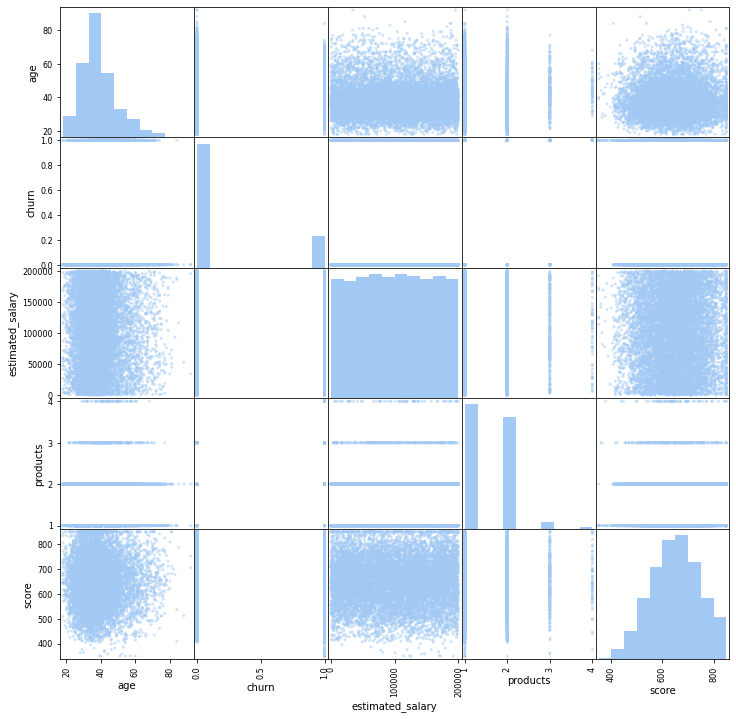

In [70]:
df_corr = df.pivot_table(index='userid',values=['age','estimated_salary', 'score', 'products', 'churn'], aggfunc='mean')
pd.plotting.scatter_matrix(df_corr, figsize=(12,12))
plt.show()

Корреляционный анализ показывает, что взаимосвязь между большинством рассматриваемых факторов отсутствует.
Единственный фактор, по которому выявлена слабая зависимость с параметром оттока - возраст клиента (коэффициент корреляции 0,285 что соответствует слабой положительной взаимосвязи между возрастом клиента и риском его ухода из банка).

**Промежуточный вывод**

В рамках данного этапа были проанализированы данные о 10 тыс. клиентах банка. 

Возраст клиентов банка варьируется от 18 до 92 лет. Медианный возраст 37 лет. При сопоставлении распределения возрастов оставшихся и ушедших клиентов отмечаются существенные различия: медианный возраст ушедших клиентов составляет 45 лет, половина ушедших клиентов - люди в возрасте от 38 до 52 лет. Тенденция справедлива и для мужчин, и для женщин. 

Наибольший относительный отток клиентов отмечается в группе клиентов возрастной группы "выше среднего" (старше 45 и моложе 60 лет). Это единственная возрастная группа, где число ушедших клиентов превышает число оставшихся. 

Наличие слабой зависимости между возрастом клиента и фактом его ухода из банка подтверждается и корреляционным анализом: коэффициент корреляции между возрастом клиента и фактом его ухода из банка составляет 0,285, что соответствует слабой положительной взаимосвязи между факторами.

Наибольший отток клиентов в относительном и абсолютном выражении наблюдается в Ростове Великом: там ушли 814 клиентов или почти треть клиентов банка. Значительный отток клиентов в абсолютном выражении наблюдается в Ярославле (810 человек), в относительном выражении ситуация в Ярославле и Рыбинске сопоставима.

Кредитный рейтинг клиентов банка варьируется от 350 до 850 баллов. Медианный кредитный рейтинг составляет 652 баллов. Отметим, что кредитный рейтинг ушедших клиентов банка несколько ниже кредитного рейтинга оставшихся клиентов (медианное значение кредитного рейтинга 646 баллов у ушедших клиентов, 653 балла у оставшихся клиентов).

В среднем по датасету медианная оценка заработной платы клиентов составляет 100193,9 руб. в месяц. Среди клиентов, покинувших банк, медианная оценка заработной платы несколько выше (102460,84 руб.), чем среди оставшихся клиентов (99645,04 руб.). При этом различия в средних доходах между покинувшими банк клиентами и оставшимися отмечаются только в отношении клиентов-женщин.

Отток клиентов наблюдается во всех группах клиентов, выделенных в зависимости от оценки заработной платы, но в относительном выражении он несколько выше среди клиентов с высокой оценкой заработной платы.

Клиенты банка используют от 1 до 4 продуктов. Медианное значение количества используемых продуктов как для оставшихся клиентов, так и для ушедших - 1. Это означает, что половина клиентов банка пользуются только одним продуктом.
90% клиентов банка используют 2 и менее продуктов банка. Четырьмя продуктами банка пользовались лишь отдельные ушедшие клиенты (60 человек в общей выборке 10000).

Такое неравномерное распределение свидетельствует о том, что при сегментации клиентов по числу используемых продуктов банка группы клиентов, использующих 3 и 4 продукта следует объединить.

В относительном выражении наибольший отток отмечается среди клиентов, пользовавшихся 3 или 4 банковскими продуктами. Наименьший отток - среди клиентов, использующих 2 продукта.


## Сегментация клиентов банка


На четвертом этапе будет проведен анализ распределения признаков в разрезе сегментов клиентов. В качестве базового признака сегментации будет использован показатель количества банковских продуктов, используемых клиентов. При необходимости исходя из результатов предшествующего анализа будут использоваться и иные признаки.

Исходя из проведенного анализа целесообразно сегментировать клиентов банка по двум признакам:

- количество используемых продуктов банка (1, 2 и более)
- возрастная группа клиентов банка (молодежь, средний возраст, выше среднего, пенсионеры) 

In [71]:
# выделим группы в зависимости от числа используемых продуктов

def product_group(products):
    """
    Возвращает группу клиентов в зависимости от количества используемых банковских продуктов:
    - 'один продукт', если products = 1;
    - 'два продукта', если products = 2;
    - 'более двух продуктов', если products > 2
    """
    
    if products == 1:
        return 'один продукт'
    if products == 2:
        return 'два продукта'
    return 'более двух продуктов'

df['product_group'] = df['products'].apply(product_group)
print(df['product_group'].value_counts()) 

один продукт            5084
два продукта            4590
более двух продуктов     326
Name: product_group, dtype: int64


In [72]:
# Сначала рассмотрим сегментацию только в разрезе числа используемых банковских продуктов
df_segm1 = df.pivot_table(index='product_group', aggfunc='mean')

display(df_segm1)

age        balance     churn  credit_card  \
product_group                                                           
более двух продуктов  43.653374  120074.314953  0.858896     0.708589   
два продукта          37.753595  119660.944362  0.075817     0.707190   
один продукт          39.673092  119894.163723  0.277144     0.703777   

                      estimated_salary   loyalty   missing   objects  \
product_group                                                          
более двух продуктов     104400.141503  0.435583  0.343558  5.058282   
два продукта             100452.012821  0.532898  0.566449  5.051852   
один продукт              99487.256851  0.504131  0.178009  4.974626   

                      products  rostov_d  rybinsk_d       score        userid  \
product_group                                                                   
более двух продуктов  3.184049  0.368098   0.223926  649.113497  1.573768e+07   
два продукта          2.000000  0.226580   0.257734  652.188671  1.573484e+07   
один продукт          1.000000  0.265342   0.240165  649.120968  1.573237e+07   

                      yaroslavl_d  
product_group                      
более двух продуктов     0.407975  
два продукта             0.515686  
один продукт             0.494493

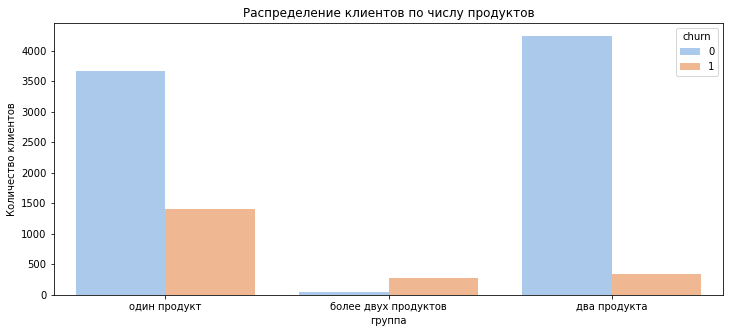

In [73]:
hist_graph(df, "product_group", "churn", 'Распределение клиентов по числу продуктов', 'группа') 

По результатам сегментации в зависимости от числа используемых продуктов мы получили три группы клиентов.

*Клиенты, использующие 1 продукт* - самая многочисленная группа клиентов (50,84% в общей численности). Средний возраст клиентов в группе 39,67 лет, средний кредитный рейтинг 649,12 балла, средняя оценка заработной платы 99,5 тыс. руб., 50,4% клиентов группы являются активными, отток из группы составил 27,7%.

*Клиенты, использующие 2 продукта* - вторая по численности группа клиентов банка (45,9%). Средний возраст клиентов 37,7 лет, средний кредитный рейтинг 652,2 балла, средняя оценка заработной платы 100,5 тыс. руб., 53,3% клиентов группы являются активными. Это наиболее благополучная группа с точки зрения оттока клиентов: доля ушедших клиентов составила лишь 7,6%.

*Клиенты, использующие 3 и более продуктов банка* - наименьшая по численности клиентов группа (3,3% клиентов) и наиболее проблемная группа с точки зрения оттока клиентов (85,9% группы покинули банк). Средний возраст клиентов 43,7 лет, средний кредитный рейтинг 649,1 балл, 43,5% клиентов группы считаются активными, средняя оценка заработной платы - 104,4 рублей.

In [74]:
# Дополнительно выделим возрастные сегменты среди клиентов, использующих 1 или 2 продукта

df_segm2 = df.loc[df['product_group'] !='более двух продуктов']
df_segm3 = df_segm2.pivot_table(index=['product_group', 'age_group'], aggfunc='mean').reset_index()

display(df_segm3)
df_segm4 = df_segm2.pivot_table(index=['product_group', 'age_group'], values='userid', aggfunc='count')
display(df_segm4)



product_group        age_group        age        balance     churn  \
0  два продукта    выше среднего  50.981584  118780.034474  0.235727   
1  два продукта         молодежь  25.970896  119698.584575  0.029104   
2  два продукта       пенсионеры  68.010204  121606.160000  0.127551   
3  два продукта  средний возраст  36.753676  119711.496523  0.056818   
4  один продукт    выше среднего  51.332663  120703.938716  0.609045   
5  один продукт         молодежь  25.858278  121836.251664  0.108609   
6  один продукт       пенсионеры  67.257028  117564.603971  0.301205   
7  один продукт  средний возраст  37.067099  119344.086530  0.209400   

   credit_card  estimated_salary   loyalty   missing   objects  products  \
0     0.697974     101502.245912  0.626151  0.510129  5.046041         2   
1     0.707800     101803.338091  0.498254  0.603027  5.179278         2   
2     0.739796     103462.724031  0.882653  0.591837  4.637755         2   
3     0.706551      99676.222590  0.503008  0.564505  5.043449         2   
4     0.701508      98200.332000  0.473367  0.217085  4.971859         1   
5     0.717881      99386.616689  0.525828  0.148344  5.013245         1   
6     0.686747      93078.887992  0.775100  0.180723  5.068273         1   
7     0.702431     100444.196039  0.486872  0.172447  4.958509         1   

   rostov_d  rybinsk_d       score        userid  yaroslavl_d  
0  0.248619   0.276243  647.029466  1.573437e+07     0.475138  
1  0.199069   0.257276  652.798603  1.573328e+07     0.543655  
2  0.209184   0.260204  659.923469  1.574098e+07     0.530612  
3  0.231618   0.254345  652.443182  1.573497e+07     0.514037  
4  0.330653   0.226131  646.864322  1.573575e+07     0.443216  
5  0.255629   0.227815  649.883444  1.573055e+07     0.516556  
6  0.265060   0.269076  650.076305  1.572626e+07     0.465863  
7  0.246677   0.245381  649.585089  1.573221e+07     0.507942

userid
product_group age_group              
два продукта  выше среднего       543
              молодежь            859
              пенсионеры          196
              средний возраст    2992
один продукт  выше среднего       995
              молодежь            755
              пенсионеры          249
              средний возраст    3085

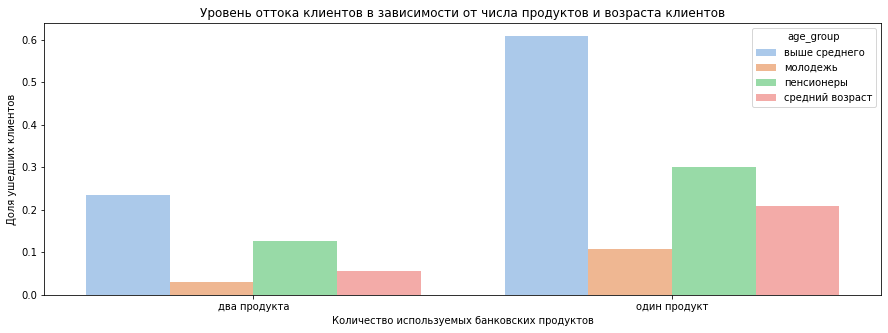

In [76]:
plt.figure(figsize=(15,5))
ax=sns.barplot(data=df_segm3, x="product_group", y="churn", hue="age_group")
ax.set_title('Уровень оттока клиентов в зависимости от числа продуктов и возраста клиентов')
ax.set_xlabel('Количество используемых банковских продуктов')
ax.set_ylabel('Доля ушедших клиентов')
plt.show()

Дальнейшая сегментация группы клиентов, использующих 1 продукт, по возрастным группам, показывает, что активность и отток клиентов этой общей группы значительно меняется с возрастом клиентов. 

Так, минимальный отток клиентов, пользующихся одним продуктом, среди молодежи (клиентов в возрасте до 29 лет включительно) - 10,9%. В этой же группе наибольшее число активных клиентов (77,5%).

Несколько выше уровень оттока среди клиентов среднего возраста (20,9%). Активных клиентов в этой группе 48,6%. Наибольший отток отмечается среди клиентов в возрасте 45 - 60 лет: 60,9% клиентов этого возраста, использовавших один продукт банка, ушли. Отметим, что в этой группе несколько ниже рейтинг кредитоспособности клиентов (в среднем 646,86 балла). Заметен отток и в группе пенсионеров: он составил 30,1% среди тех, кто пользовался одним продуктом банка.

Анализ группы клиентов, использующих 2 продукта, по возрастам, также показывает, что наибольший отток заметен среди клиентов 45-60 лет. Однако масштаб оттока значительно ниже, чем среди тех, кто пользовался только одним продуктом банка. Так, максимальный отток среди клиентов, использующих 2 продукта, составил 23,6% (для клиентов старше среднего возраста), 12,8% среди пенсионеров и менее 6% в остальных возрастных группах.


**Промежуточные выводы**

По итогам сегментации выделены следующие группы клиентов банка по приоритетности работы для предотвращения оттока клиентов:

1. *Группа, требующая немедленного внимания* - это клиенты, пользующиеся 3-4 продуктами банка. В этой группе отмечается наибольший отток клиентов (85,9%), хотя сама группа невелика (3,3% датасета). Средний возраст клиентов 43,7 лет, средний кредитный рейтинг 649,1 балл, 43,5% клиентов группы считаются активными, средняя оценка заработной платы - 104,4 рублей. 

Вероятно, повышенный отток клиентов этой группы связан с более привлекательными условиями программ лояльности других банков. Рекомендуется проработать программу лояльности для клиентов, пользующихся более чем 2-мя банковскими продуктами.

2. *Группа, требующая повышенного внимания* - это клиенты в возрасте от 45 до 60 лет, пользующиеся 1 продуктом банка. Отток в этой группе составляет 60,9%. В этой группе несколько ниже рейтинг кредитоспособности клиентов (в среднем 646,86 балла). На эту группу приходится 10% клиентов банка.

Вероятно, повышенный отток клиентов связан с отсутствием привлекательных банковских продуктов для клиентов этой категории. Рекомендуется рассмотреть возможность разработки специальных продуктов для клиентов в возрасте 45+, в том числе и кредитных.

3. *Группы, требующие внимания* - это сегменты клиентов с уровнем оттока от 10% до 30,1% (в общей сложности на них приходится 48,2% клиентов банка). В составе этих групп можно выделить следующие:

- *Лояльные пенсионеры* - клиенты пенсионного возраста, пользующиеся 2-мя продуктами банка. Отток в этой группе составляет 12,8% (ниже среднего по банку), уровень активности 88,2%, средний остаток на счетах 121,6 тыс. руб. Чтобы дополнительно снизить отток в этой группе и группе "пенсионеры в зоне риска" рекомендуется рассмотреть введение специальных пенсионных продуктов.

- *Лояльные зрелые* - клиенты в возрасте выше среднего, пользующиеся 2-мя продуктами банка. Отток в группе составляет 23,6%, уровень активности 62,6%, кредитный рейтинг - 647 баллов. Отток в этой группе максимальный среди клиентов, пользующихся 2-мя продуктами банка. Удержанию таких клиентов может способствовать введение специальных продуктов, в т.ч. кредитных, для клиентов в возрасте 45+.

- *Относительно лояльные клиенты в возрасте до 45 лет* - клиенты в возрасте до 45 лет, пользующиеся 1 продуктом банка. Отток среди представителей среднего возраста составляет 20,9%, среди молодежи - 10,8%. Кредитный рейтинг в среднем составляет 649 баллов. Для противодействия оттоку клиентов в этой группе рекомендуется рассмотреть возможность продвижения программ лояльности: в случае использования 2 продуктов эта группа может стать наиболее лояльной.

- *Пенсионеры в зоне риска* - клиенты в возрасте старше 60 лет, пользующиеся 1 продуктом банка. Отток в группе составляет 30,1%, доля активных пользователей 77,5%, средний остаток на счетах 117,6 руб. Для удержания таких клиентов целесообразно рассмотреть специальные продукты для пенсионеров. Особенно в свете действующих программ других банков по начислению бонусных сумм при переводе пенсий в банк.

4. *Наиболее лояльная группа* - клиенты в возрасте до 45 лет, пользующиеся 2-мя продуктами банка. На группу приходится 38,5% клиентов банка. В этой группе отток минимален и не превышает 6%. Средний кредитный рейтинг клиентов 652 балла, средний остаток на счетах - 99,7 тыс. руб., уровень активности клиентов - около 50%.

## Статистическое исследование данных

На пятом этапе будут сформулированы и проверены с помощью статистических тестов 2 гипотезы, позволяющие выявить причины оттока клиентов банка либо факторы, способствующие удержанию клиентов.

В соответствии с заданием, необходимо проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

Для проведения статистического исследования сформулируем нулевую и альтернативную гипотезы:
Нулевая гипотеза: средний доход клиентов, пользующихся двумя продуктами банка, равен среднему доходу клиентов, пользующихся одним продуктом банка.
Альтернативная гипотеза: средний доход клиентов, пользующихся двумя продуктами банка, отличается от среднего дохода клиентов, пользущихся одним продуктом банка.

Для сравнения воспользуемся статистическим t-тестом. Поскольку наполняемость групп различается, установим по умолчанию, что дисперсии выборок не равны.

In [77]:
# выборка 1 - оценка доходов клиентов, пользующихся одним продуктом банка
sample_1 = df.loc[df['products']==1]['estimated_salary']

# выборка 2 - оценка доходов клиентов, пользующихся двумя продуктами банка
sample_2 = df.loc[df['products']==2]['estimated_salary']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


По результатам статистического теста не получилось отвергнуть нулевую гипотезу. Нет оснований считать различия в доходах клиентов, пользующихся одним продуктом банка, и клиентов, пользующихся двумя продуктами банка, разными.

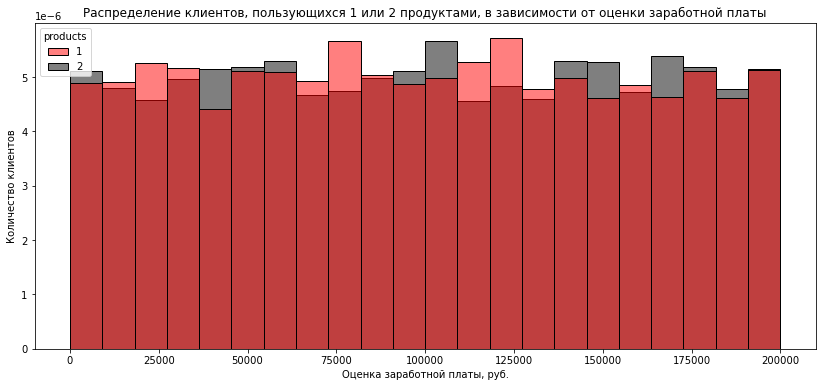

In [81]:
plt.figure(figsize=(14,6))
ax = sns.histplot(
    data=df.loc[df['products']<3],hue="products",x="estimated_salary",stat="density",common_norm=False,palette="flag"
)
ax.set_title('Распределение клиентов, пользующихся 1 или 2 продуктами, в зависимости от оценки заработной платы')
ax.set_xlabel('Оценка заработной платы, руб.')
ax.set_ylabel('Количество клиентов')
plt.show()

С целью подтверждения результатов сегментации клиентов проверим статистическую гипотезу о равенстве уровня оттока клиентов среди клиентов, пользующихся одним продуктом банка, и клиентов, пользующихся двумя продуктами банка.

Нулевая гипотеза: доля ушедших клиентов в группах клиентов, пользующихся одним продуктом банка, и пользующихся двумя продуктами банка, не отличается.
Альтернативная гипотеза: доля ушедших клиентов в группах клиентов, пользующихся одним продуктом банка, и пользующихся двумя продуктами банка, отличается.

Для проверки гипотезы используем z-тест.

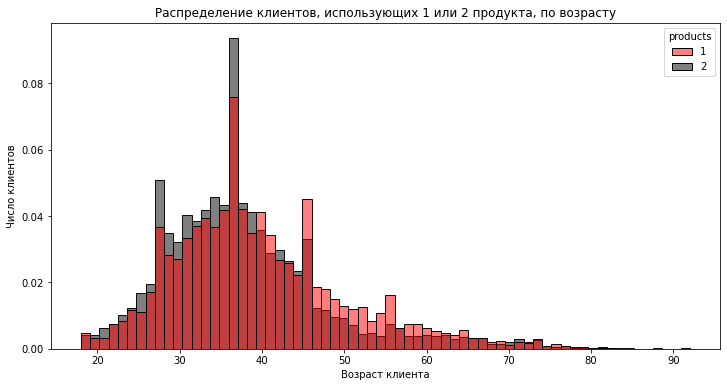

In [82]:
plt.figure(figsize=(12,6))
ax = sns.histplot(data=df.loc[df['products']<3],hue="products",x="age",stat="density",common_norm=False,palette="flag")
ax.set_title('Распределение клиентов, использующих 1 или 2 продукта, по возрасту')
ax.set_xlabel('Возраст клиента')
ax.set_ylabel('Число клиентов')
plt.show()

В целом распределение клиентов данных групп близко к нормальному, что позволяет использовать z-тест.

In [83]:
#Рассчитаем переменные, необходимые для z-теста

left1 = df.loc[df['products']==1]['churn'].sum()
left2 = df.loc[df['products']==2]['churn'].sum()

total1 = df.loc[df['products']==1]['userid'].count()
total2 = df.loc[df['products']==2]['userid'].count()


In [84]:
alpha = .05 # критический уровень статистической значимости

left = np.array([left1, left2])
total = np.array([total1, total2])

# уровень оттока в первой группе:
p1 = left[0]/total[0]

# уровень оттока во второй группе:
p2 = left[1]/total[1]

# пропорция оттока в комбинированном датасете:
p_combined = (left[0] + left[1]) / (total[0] + total[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


В рамках сегментации клиентов были сделаны выводы о различиях в уровне оттока клиентов банков в зависимости от возраста (в частности, о более высоком оттоке клиентов в возрасте 45-60 лет). Проверим значимость этих различий статистически.

Нулевая гипотеза: доля ушедших клиентов в возрасте 45-60 лет и в других возрастах, не отличается.
Альтернативная гипотеза: доля ушедших клиентов в возрасте 45-60 лет отличается от доли клиентов, ушедших из банка, в других возрастных группах.

Для проверки гипотезы используем z-тест.


In [85]:
#Рассчитаем переменные, необходимые для z-теста

left1 = df.loc[df['age_group']=='выше среднего']['churn'].sum()
left2 = df.loc[df['age_group']!='выше среднего']['churn'].sum()

total1 = df.loc[df['age_group']=='выше среднего']['userid'].count()
total2 = df.loc[df['age_group']!='выше среднего']['userid'].count()


In [86]:
alpha = .05 # критический уровень статистической значимости

left = np.array([left1, left2])
total = np.array([total1, total2])

# уровень оттока в первой группе:
p1 = left[0]/total[0]

# уровень оттока во второй группе:
p2 = left[1]/total[1]

# пропорция оттока в комбинированном датасете:
p_combined = (left[0] + left[1]) / (total[0] + total[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Промежуточный вывод**

Результаты статистического анализа показали, что:
    
    - нет оснований считать уровень дохода клиентов, пользующихся одним продуктом банка, и клиентов, пользующихся двумя продуктами банка, различным;
    
    - уровень оттока клиентов в группе клиентов, пользующихся одним продуктом банка, статистически значимо отличается от уровня оттока клиентов, пользующихся двумя продуктами банка;
    
    - уровень оттока клиентов в возрасте 45-60 лет значимо отличается от уровня оттока клиентов в других возрастных группах.
    
    

## Выводы и рекомендации по удержанию клиентов

На данном этапе представлены:

- краткое описание проделанных работ;
- описание сегментов клиентов банка и результатов их анализа;
- рекомендации по удержанию клиентов банка на основе проведенного анализа;
- презентация с результатами проведенного исследования.

**Краткое описание проведенной работы**

*Цель проекта* - разработать предложения по снижению уровня оттока клиентов банка "Метанпром".

Для достижения цели проекта были решены следующие задачи:

• проведена предварительная обработка данных

• проведен исследовательский анализ данных о клиентах банка

• проведена сегментация клиентов банка исходя из потребления банковских продуктов и иных значимых факторов

• проверены гипотезы, характеризующие факторы оттока клиентов из банка

• сформулированы рекомендации по удержанию клиентов банка

*Исходные данные*

Датасет, содержащий данные о 10 тыс. клиентов банка (баллы кредитного скоринга, город, пол, возраст, количество объектов в собственности, баланс на счете, количество используемых продуктов, наличие кредитной карты, активность, оценка заработной платы, факт оттока из банка).

На этапе *предварительной обработки данных* проведена проверка датасета на наличие некорректных значений и дубликатов (не выявлены). В столбце "баланс счета" выявлены пропуски (заполнено 6383 значение из 10000). 

Анализ пропусков показал, что пропущенные данные о балансе встречаются в двух из трех филиалов банка (в г. Ярославль и г. Рыбинск). При этом факт пропуска данных не зависит от факта ухода клиента, признаков его активности, количества используемых продуктов, наличия кредитной карты, возраста, оценки уровня заработной платы или кредитного рейтинга.

Можно предположить, что в г.Ярославле и г. Рыбинск данные об остатках на счетах клиентов стали вносить в базу данных недавно, и поэтому по части клиентов они отсутствуют.

Оценка заработной платы, возраст, кредитный рейтинг не коррелируют с балансом на счету клиента, что не позволяет использовать указанные признаки для более точного заполнения пропусков. Пропуски составляют значительную часть общей базы, и исключение из анализа указанных клиентов для всего этапа исследовательского анализа может привести к некорректным выводам.

По итогам *исследовательского анализа данных* сформулированы следующие выводы:

- Возраст клиентов банка варьируется от 18 до 92 лет. Медианный возраст 37 лет. При сопоставлении распределения возрастов оставшихся и ушедших клиентов отмечаются существенные различия: медианный возраст ушедших клиентов составляет 45 лет, половина ушедших клиентов - люди в возрасте от 38 до 52 лет. Тенденция справедлива и для мужчин, и для женщин. 

- Наибольший относительный отток клиентов отмечается в группе клиентов возрастной группы "выше среднего" (старше 45 и моложе 60 лет). Это единственная возрастная группа, где число ушедших клиентов превышает число оставшихся. 

- Наличие зависимости между возрастом клиента и фактом его ухода из банка подтверждается и корреляционным анализом: коэффициент корреляции между возрастом клиента и фактом его ухода из банка составляет 0,285, что соответствует слабой положительной взаимосвязи между факторами.

- Наибольший отток клиентов в относительном и абсолютном выражении наблюдается в Ростове Великом: там ушли 814 клиентов или почти треть клиентов банка. Значительный отток клиентов в абсолютном выражении наблюдается в Ярославле (810 человек), в относительном выражении ситуация в Ярославле и Рыбинске сопоставима.

- Кредитный рейтинг клиентов банка варьируется от 350 до 850 баллов. Медианный кредитный рейтинг составляет 652 баллов. Отметим, что кредитный рейтинг ушедших клиентов банка несколько ниже кредитного рейтинга оставшихся клиентов (медианное значение кредитного рейтинга 646 баллов у ушедших клиентов, 653 балла у оставшихся клиентов).

- В среднем по датасету медианная оценка заработной платы клиентов составляет 100193,9 руб. в месяц. Среди клиентов, покинувших банк, медианная оценка заработной платы несколько выше (102460,84 руб.), чем среди оставшихся клиентов (99645,04 руб.). При этом некоторые различия в средних доходах между покинувшими банк клиентами и оставшимися отмечаются только в отношении клиентов-женщин.

- Отток клиентов наблюдается во всех группах клиентов, выделенных в зависимости от оценки заработной платы, но в относительном выражении он несколько выше среди клиентов с высокой оценкой заработной платы.

- Клиенты банка используют от 1 до 4 продуктов. Медианное значение количества используемых продуктов как для оставшихся клиентов, так и для ушедших - 1. Это означает, что половина клиентов банка пользуются только одним продуктом. 90% клиентов банка используют 2 и менее продуктов банка. Четырьмя продуктами банка пользовались лишь отдельные ушедшие клиенты (60 человек в общей выборке 10000).

- Такое неравномерное распределение свидетельствует о том, что при сегментации клиентов по числу используемых продуктов банка группы клиентов, использующих 3 и 4 продукта следует объединить.

- В относительном выражении наибольший отток отмечается среди клиентов, пользовавшихся 3 или 4 банковскими продуктами. Наименьший отток - среди клиентов, использующих 2 продукта.
    

**Описание сегментов клиентов банка и результатов их анализа**

По итогам сегментации выделены следующие группы клиентов банка по приоритетности работы для предотвращения оттока клиентов:

1. *Группа, требующая немедленного внимания* - это клиенты, пользующиеся 3-4 продуктами банка. В этой группе отмечается наибольший отток клиентов (85,9%), хотя сама группа невелика (3,3% датасета). Средний возраст клиентов 43,7 лет, средний кредитный рейтинг 649,1 балл, 43,5% клиентов группы считаются активными, средняя оценка заработной платы - 104,4 рублей. 

Вероятно, повышенный отток клиентов этой группы связан с более привлекательными условиями программ лояльности других банков. Рекомендуется проработать программу лояльности для клиентов, пользующихся более чем 2-мя банковскими продуктами.

2. *Группа, требующая повышенного внимания* - это клиенты в возрасте от 45 до 60 лет, пользующиеся 1 продуктом банка. Отток в этой группе составляет 60,9%. В этой группе несколько ниже рейтинг кредитоспособности клиентов (в среднем 646,86 балла). 

Вероятно, повышенный отток клиентов связан с отсутствием привлекательных банковских продуктов для клиентов этой категории. Рекомендуется рассмотреть возможность разработки специальных продуктов для клиентов в возрасте 45+, в том числе и кредитных.

3. *Группы, требующие внимания* - это сегменты клиентов с уровнем оттока от 10% до 30,1%. В составе этих групп можно выделить следующие:

- *Лояльные пенсионеры* - клиенты пенсионного возраста, пользующиеся 2-мя продуктами банка. Отток в этой группе составляет 12,8% (ниже среднего по банку), уровень активности 88,2%, средний остаток на счетах 121,6 тыс. руб. Чтобы дополнительно снизить отток в этой группе и группе "пенсионеры в зоне риска" рекомендуется рассмотреть введение специальных пенсионных продуктов.

- *Лояльные зрелые* - клиенты в возрасте выше среднего, пользующиеся 2-мя продуктами банка. Отток в группе составляет 23,6%, уровень активности 62,6%, кредитный рейтинг - 647 баллов. Отток в этой группе максимальный среди клиентов, пользующихся 2-мя продуктами банка. Удержанию таких клиентов может способствовать введение специальных продуктов, в т.ч. кредитных, для клиентов в возрасте 45+.

- *Относительно лояльные клиенты в возрасте до 45 лет* - клиенты в возрасте до 45 лет, пользующиеся 1 продуктом банка. Отток среди представителей среднего возраста составляет 20,9%, среди молодежи - 10,8%. Кредитный рейтинг в среднем составляет 649 баллов. Для противодействия оттоку клиентов в этой группе рекомендуется более активно продвигать (рекламировать) имеющиеся банковские продукты, а также предоставлять некоторые бонусы при подключении второго продукта. Это позволит относительно лояльным клиентам перейти в наиболее лояльную группу.

- *Пенсионеры в зоне риска* - клиенты в возрасте старше 60 лет, пользующиеся 1 продуктом банка. Отток в группе составляет 30,1%, доля активных пользователей 77,5%, средний остаток на счетах 117,6 руб. Для удержания таких клиентов целесообразно рассмотреть специальные продукты для пенсионеров. Особенно в свете действующих программ других банков по начислению бонусных сумм при переводе пенсий в банк.

4. *Наиболее лояльная группа* - клиенты в возрасте до 45 лет, пользующиеся 2-мя продуктами банка. В этой группе отток минимален и не превышает 6%. Средний кредитный рейтинг клиентов 652 балла, средний остаток на счетах - 99,7 тыс. руб., уровень активности клиентов - около 50%.

**Результаты статистического анализа**

Результаты статистического анализа показали, что:
    
    - нет оснований считать уровень дохода клиентов, пользующихся одним продуктом банка, и клиентов, пользующихся двумя продуктами банка, различным;    
    - уровень оттока клиентов в группе клиентов, пользующихся одним продуктом банка, статистически значимо отличается от уровня оттока клиентов, пользующихся двумя продуктами банка;
    - уровень оттока клиентов в возрасте 45-60 лет значимо отличается от уровня оттока клиентов в других возрастных группах.
    

**Рекомендации по удержанию клиентов банка**

1. С целью преодоления оттока клиентов необходимо уделить приоритетное внимание клиентам, использующим 3-4 продукта банка. Анализ показал, что отток в этой группе крайне высок. Возможно, это связано с отсутствием (недостаточной привлекательностью) программы лояльности банка, особенно по сравнению с премиальными программами конкурирующих банков. В рамках такой программы лояльности могут рассматриваться повышенные ставки по депозитам или программы льготного кредитования для клиентов, активно пользующихся продуктами банка.

2. Отдельное внимание следует сосредоточить на клиентах в возрасте 45-60 лет, особенно на тех, кто пользуется одним продуктом банка. Высокий уровень оттока этих клиентов может быть обусловлен отсутствием специальных банковских продуктов, востребованных этой возрастной категорией, а также, возможно, более жесткими требованиями при принятии решений о предоставлении кредитов (предположение связано с несколько более низким рейтингом клиентов данной возрастной группы). В качестве возможного решения предлагается рассмотреть введение специальной кредитной линии "45+" для клиентов старше 45 лет, не вышедших на пенсию.

3. Ощутимый отток пенсионеров (особенно среди клиентов, пользующихся только одним банковским продуктом) может быть связан с единовременным поощрением, предлагаемым банками-конкурентами при переводе к ним пенсионных выплат. Для противодействия такому оттоку необходимо предложить собственный привлекательный пенсионный продукт, например, карту с кэшбэком для клиентов, оставляющих счета для получения пенсии в банке.

4. Для противодействия оттоку клиентов в группе "относительно лояльных клиентов в возрасте до 45 лет" (клиентов, использующих 1 продукт банка) рекомендуется более активно продвигать (рекламировать) имеющиеся банковские продукты, а также предоставлять некоторые бонусы при подключении второго продукта. Это позволит относительно лояльным клиентам перейти в наиболее лояльную группу.